In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch

In [3]:
russian = torch.load('checkpoint_90_epoch.pth')

In [36]:
bashkir = torch.load('checkpoint_90_ba_epoch.pth')

In [41]:
russian.keys()

dict_keys(['epoch', 'encoder_state_dict', 'decoder_state_dict', 'encoder_optimizer_state_dict', 'decoder_optimizer_state_dict', 'criterion_state_dict', 'plot_losses', 'print_loss_total', 'plot_loss_total', 'start'])

In [19]:
losses = russian['plot_losses']
n_epochs = [count for count in range(1, len(losses) + 1)]

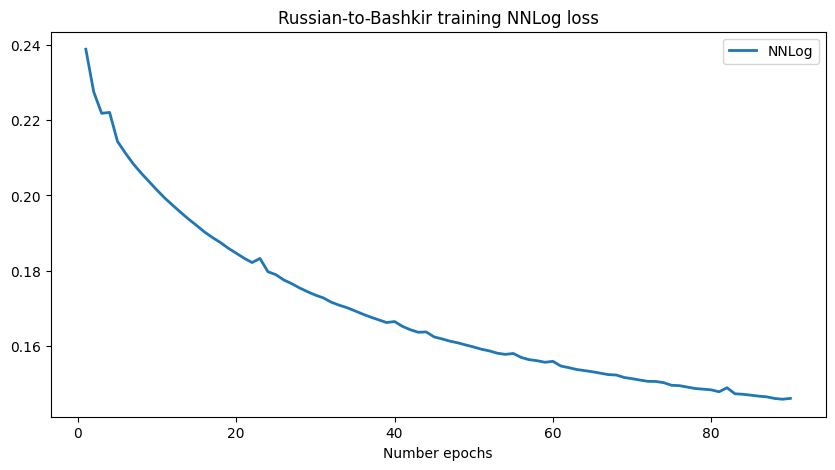

In [35]:
# make data
x = n_epochs
y = losses

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title("Russian-to-Bashkir training NNLog loss")
ax.set_xlabel('Number epochs')

plt.plot(x, y, linewidth=2.0)
plt.legend(['NNLog'])
plt.show()

In [37]:
losses = bashkir['plot_losses']
n_epochs = [count for count in range(1, len(losses) + 1)]

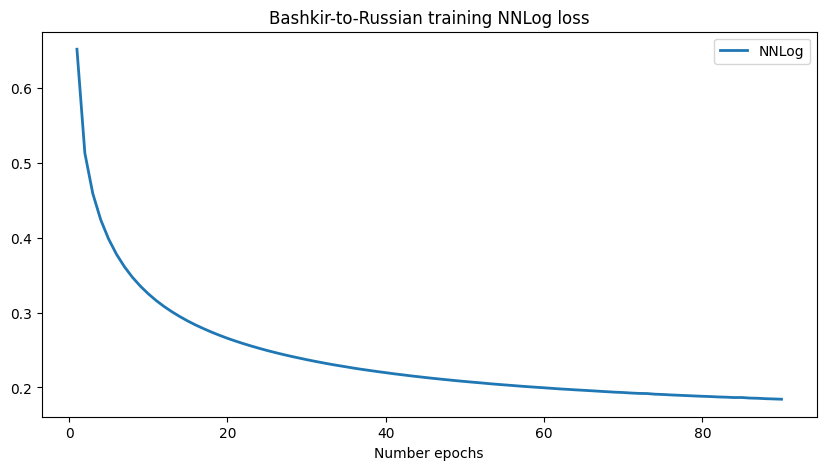

In [38]:
# make data
x = n_epochs
y = losses

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title("Bashkir-to-Russian training NNLog loss")
ax.set_xlabel('Number epochs')

plt.plot(x, y, linewidth=2.0)
plt.legend(['NNLog'])
plt.show()

In [175]:
def readLangs():
    print("Reading lines...")


    with open("text\\bashinform_new\\bashinform 11.09.2021 - 16.04.2022.txt", "r", encoding='utf-8') as ba_1:
        lines = ba_1.readlines()

    translate_pair = []
    compare_pair = []

    for line in lines:
        if '@' in line:
            columns = line.split('@')
        if columns[0] not in translate_pair:
            translate_pair.append(columns[0])
            compare_pair.append(columns[1])
    

    return translate_pair, compare_pair

In [176]:
translate_pair, compare_pair = readLangs()

Reading lines...


In [177]:
len(translate_pair) == len(compare_pair)

True

In [22]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load('load\\target.model')

True

In [27]:
a = [["The cat is sitting on the mat".split()]]
a

[[['The', 'cat', 'is', 'sitting', 'on', 'the', 'mat']]]

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from train import readLines

# Example machine-generated translations
translations = [
    ["The cat sat on the mat".split()],
    ["It's raining cats and dogs".split()]
]

# Example reference translations
references = [
    [["The cat is sitting on the mat".split()]],
    [["It is raining heavily".split(), "It is raining cats and dogs".split()]]
]

# Compute BLEU score
bleu_score = corpus_bleu(references, translations)

# Print BLEU score
print("BLEU Score:", bleu_score)

In [28]:
import torch
import pickle  # to load all our vocabularies and language decoder/encoder
import sentencepiece as spm
import re

In [29]:
EOS_token = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 128

In [113]:
# to merge digits during inference
def merge_digits(text):
    # regular expression pattern to match separated digits
    pattern = r"\b\d+(?:\s+\d+)*(?:\s*:\s*\d+(?:\s+\d+)*)*\b"

    # function to replace the matched separated digits
    def replace(match):
        parts = re.split(r"\s*:\s*", match.group())
        merged_parts = ["".join(part.split()) for part in parts]
        return ":".join(merged_parts)

    # Perform the replacement using the regular expression
    merged_text = re.sub(pattern, replace, text)

    return merged_text


# to split during inference
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)


def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [31]:
# loading our tokenizer models
sp_ba = spm.SentencePieceProcessor()
sp_ba.Load("load\\target.model")
sp_ru = spm.SentencePieceProcessor()
sp_ru.Load("load\\source.model")


# loading our vocabularies
with open("load\\ru_input_lang.pkl", "rb") as f:
    ru_input_lang = pickle.load(f)
with open("load\\ru_output_lang.pkl", "rb") as f:
    ru_output_lang = pickle.load(f)

with open("load\\ba_input_lang.pkl", "rb") as f:
    ba_input_lang = pickle.load(f)
with open("load\\ba_output_lang.pkl", "rb") as f:
    ba_output_lang = pickle.load(f)

# loading both language encoders and decoders
with open("load\\ru_encoder.pkl", "rb") as f:
    ru_encoder = pickle.load(f)
with open("load\\ru_decoder.pkl", "rb") as f:
    ru_decoder = pickle.load(f)

with open("load\\ba_encoder.pkl", "rb") as f:
    ba_encoder = pickle.load(f)
with open("load\\ba_decoder.pkl", "rb") as f:
    ba_decoder = pickle.load(f)


# loading training parameters
checkpoint_ru = torch.load("load\\checkpoint_90_epoch.pth")
checkpoint_ba = torch.load("load\\checkpoint_90_ba_epoch.pth")

ru_encoder.load_state_dict(checkpoint_ru["encoder_state_dict"])
ru_decoder.load_state_dict(checkpoint_ru["decoder_state_dict"])

ba_encoder.load_state_dict(checkpoint_ba["encoder_state_dict"])
ba_decoder.load_state_dict(checkpoint_ba["decoder_state_dict"])


# setting up evalution mode
ru_encoder.eval()
ru_decoder.eval()

ba_encoder.eval()
ba_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(83333, 128)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=128, out_features=128, bias=True)
    (Ua): Linear(in_features=128, out_features=128, bias=True)
    (Va): Linear(in_features=128, out_features=1, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=83333, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [196]:
translated_pair = []
for test in translate_pair:

    input_sentence = test
    encoder, decoder = ru_encoder, ru_decoder
    input_lang, output_lang = ru_input_lang, ru_output_lang
    token_encoder, token_decoder = sp_ru, sp_ba
    input_sentence = input_sentence.strip()
    input_sentence = token_encoder.encode_as_pieces(input_sentence)
    input_sentence = " ".join([token for token in input_sentence])

    output_words, _ = evaluate(
        encoder, decoder, input_sentence, input_lang, output_lang
    )
    result_words = []
    for word in output_words:
        word = token_decoder.decode_pieces(word)
        result_words.append(word)
    result_words = result_words[:-1]
    result_words = ' '.join([str(w) for w in result_words])
    result_words = result_words.split()
    translated_pair.append(result_words)

d:\bashkir_machine_translation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:1100: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


KeyError: 'Заимова'

In [206]:
compare_pair = compare_pair[:3361]

In [207]:
len(compare_pair) == len(translated_pair)

True

In [209]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

# Compute BLEU score
bleu_score = corpus_bleu(translated_pair, compare_pair)

# Print BLEU score
print("BLEU Score:", bleu_score)

BLEU Score: 0.28498793858892524
